# Predicting  profit and Driving Business Insights using Iowa spirits sales

# Pre-processing and Training Data Development


There are 3 major steps that we are planning to address in this notebook:
1. pre-precessing for our main Business problem, Prediction of Profit for Iowa's Dept of Beverages from Spirits sales.
2. pre-processing for another Business problem from our Modeling part: assisting a Liquor Store owner to select the optimal location for a new store.
3. Customer Segmentation with RFM and Unsupervised Clustering

As a reminder from the previous 2 notebooks, these are the identified Business Problems that we had in mind and are following with this whole project:

1. Exploring the impact of Covid-19 on the Iowa's Spirits Sales. considering the data contains all spirits purchased and sold by the Dept. of Alcoholic Beverages, and not just a sample, we can say with a higher degree of confidence that our findings are representative for the state of Iowa and furthermore for USA market.


2. In our EDA notebook we also explore the Volume of spirits sold by the State to the stores. This allowed us to visialize trends in the needed storage Capacity. While we are unaware of how much store capacity exists at the moment, the visualizations can prove usefull to predict future storage needs and adjust your warehousing accordingly.


3. In this Notebook apart from pre-processing data for our Modeling part, we will conduct Customer Segmentation with RFM and Unsupervised Clustering.
    * For our RFM cohort analysis we will used the dates of purchase, Store Names and Sales amount. 
    * For the Clustering part we will use KMeans with 2 different sets of metrics to choose the optimal number of clusters: Elbow method and The Silhouette Scores & Plots.
    * Lastly, as a caveat for this Customer Segmentation, we have to add that even though RFM segmentation is a marketing method usually done by retail stores to clasify their end-users/customers, we considered this to be an effective method for the State Dept. of Commerce to understand their customer base and establish appropriate courses of actions to meet their customers needs.
    
    
4. In our last part of this project ther are two more Business problems that we want to address. One is using time series analysis and predictions to forecast sales for next month for a hypothetical liquor store.


5. Lastly, we want to assist a hypothetical liquor store owner in Iowa in expanding to new locations throughout the state.

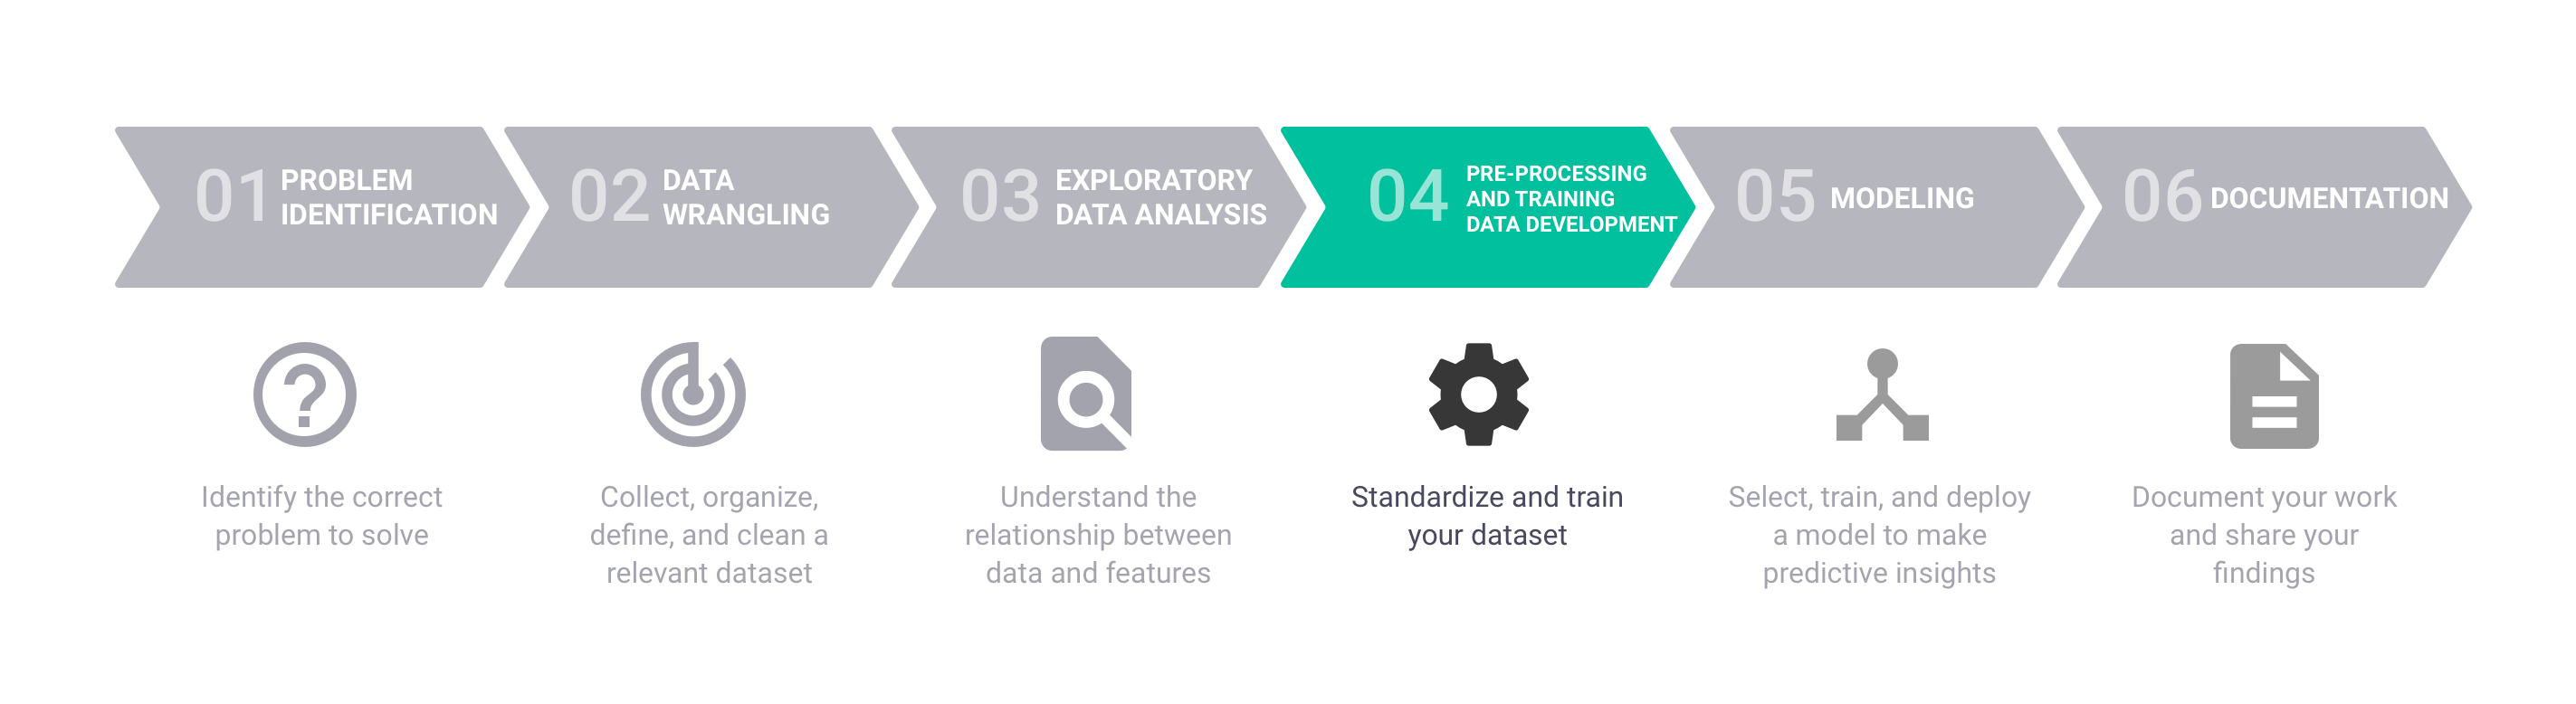

In [1]:
#Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 6)
import seaborn as sns
sns.set_theme(style="whitegrid")
import datetime as dt

np.random.seed(123)

from scipy import stats
 
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_samples, silhouette_score

import warnings
warnings.filterwarnings('ignore')

### Loading data

In [8]:
df = pd.read_csv('../data/interim/cust_seg_df.csv', parse_dates = [0])
df

,Date,Store Name,Sale (Dollars)
0,2016-03-24,Hillstreet News and Tobacco,243.00
1,2016-03-24,Hillstreet News and Tobacco,156.12
2,2016-03-24,Hillstreet News and Tobacco,477.60
3,2016-03-17,Hillstreet News and Tobacco,450.00
4,2016-03-24,Hillstreet News and Tobacco,79.56
...,...,...,...
21641140,2017-11-17,"Cats Eye Distillery, LLC",346.56
21641141,2018-05-23,"Green Frog Distillery, LLC",157.50
21641142,2018-07-26,Templeton Distilling LLC,246.72
21641143,2020-10-15,Rock River Distillation Company,1620.00


In [9]:
df.describe()

,Sale (Dollars)
count,2.164114e+07
mean,1.369856e+02
std,4.706013e+02
min,0.000000e+00
25%,3.228000e+01
50%,7.200000e+01
75%,1.417200e+02
max,2.795573e+05


In [10]:
df.describe(include = 'O')

,Store Name
count,21641145
unique,2506
top,Hy-Vee #3 / BDI / Des Moines
freq,181797


In [11]:
df.dtypes

Date              datetime64[ns]
Store Name                object
Sale (Dollars)           float64
dtype: object

## Cohort Analysis

### Asign acquisition month cohort

In [12]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

df['inv_month'] = df['Date'].apply(get_month)

In [13]:
grouping = df.groupby('Store Name')['inv_month']
df['cohort_month'] = grouping.transform('min')

df.head()

,Date,Store Name,Sale (Dollars),inv_month,cohort_month
0,2016-03-24,Hillstreet News and Tobacco,243.00,2016-03-01,2012-01-01
1,2016-03-24,Hillstreet News and Tobacco,156.12,2016-03-01,2012-01-01
2,2016-03-24,Hillstreet News and Tobacco,477.60,2016-03-01,2012-01-01
3,2016-03-17,Hillstreet News and Tobacco,450.00,2016-03-01,2012-01-01
4,2016-03-24,Hillstreet News and Tobacco,79.56,2016-03-01,2012-01-01


### Assign time offset values

Define function to get year, month and day integer values.

In [14]:
def get_date(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [15]:
inv_year, inv_month, _ = get_date(df, 'inv_month')

cohort_year, cohort_month, _ = get_date(df, 'cohort_month')

years_diff = inv_year - cohort_year
months_diff = inv_month - cohort_month
df['cohort_index'] = years_diff*12 + months_diff +1

df.head()

,Date,Store Name,Sale (Dollars),inv_month,cohort_month,cohort_index
0,2016-03-24,Hillstreet News and Tobacco,243.00,2016-03-01,2012-01-01,51
1,2016-03-24,Hillstreet News and Tobacco,156.12,2016-03-01,2012-01-01,51
2,2016-03-24,Hillstreet News and Tobacco,477.60,2016-03-01,2012-01-01,51
3,2016-03-17,Hillstreet News and Tobacco,450.00,2016-03-01,2012-01-01,51
4,2016-03-24,Hillstreet News and Tobacco,79.56,2016-03-01,2012-01-01,51


### Count Monthly active buying Stores from each cohort

In [16]:
grouping = df.groupby(['cohort_month', 'cohort_index'])

cohort_data = grouping['Store Name'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_data


,cohort_month,cohort_index,Store Name
0,2012-01-01,1,967
1,2012-01-01,2,952
2,2012-01-01,3,956
3,2012-01-01,4,949
4,2012-01-01,5,941
...,...,...,...
6531,2021-04-01,2,15
6532,2021-04-01,3,15
6533,2021-05-01,1,15
6534,2021-05-01,2,13


In [17]:
cohort_counts = cohort_data.pivot(index = 'cohort_month',
                                 columns = 'cohort_index',
                                 values = 'Store Name')

cohort_counts

cohort_index,1,2,3,4,5,6,7,8,9,10,...,105,106,107,108,109,110,111,112,113,114
cohort_month,,,,,,,,,,,,,,,,,,,,,
2012-01-01,967.0,952.0,956.0,949.0,941.0,945.0,934.0,939.0,929.0,933.0,...,632.0,633.0,631.0,634.0,633.0,621.0,624.0,624.0,619.0,624.0
2012-02-01,32.0,28.0,31.0,31.0,30.0,31.0,30.0,30.0,27.0,30.0,...,19.0,21.0,20.0,20.0,21.0,21.0,20.0,21.0,21.0,NaN
2012-03-01,18.0,15.0,14.0,15.0,18.0,17.0,17.0,17.0,18.0,16.0,...,15.0,15.0,15.0,15.0,15.0,16.0,14.0,16.0,NaN,NaN
2012-04-01,22.0,21.0,22.0,21.0,21.0,20.0,22.0,20.0,20.0,21.0,...,11.0,12.0,11.0,11.0,11.0,12.0,11.0,NaN,NaN,NaN
2012-05-01,12.0,11.0,12.0,12.0,12.0,12.0,11.0,11.0,11.0,10.0,...,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,18.0,13.0,15.0,16.0,14.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-01,14.0,10.0,13.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-01,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Retention rate

We will store the first column as size of cohort

In [18]:
cohort_sizes = cohort_counts.iloc[:,0]

And we will divide all values by the initial cohort size

In [19]:
retention = cohort_counts.divide(cohort_sizes, axis = 0)
retention.round(3)*100

cohort_index,1,2,3,4,5,6,7,8,9,10,...,105,106,107,108,109,110,111,112,113,114
cohort_month,,,,,,,,,,,,,,,,,,,,,
2012-01-01,100.0,98.4,98.9,98.1,97.3,97.7,96.6,97.1,96.1,96.5,...,65.4,65.5,65.3,65.6,65.5,64.2,64.5,64.5,64.0,64.5
2012-02-01,100.0,87.5,96.9,96.9,93.8,96.9,93.8,93.8,84.4,93.8,...,59.4,65.6,62.5,62.5,65.6,65.6,62.5,65.6,65.6,NaN
2012-03-01,100.0,83.3,77.8,83.3,100.0,94.4,94.4,94.4,100.0,88.9,...,83.3,83.3,83.3,83.3,83.3,88.9,77.8,88.9,NaN,NaN
2012-04-01,100.0,95.5,100.0,95.5,95.5,90.9,100.0,90.9,90.9,95.5,...,50.0,54.5,50.0,50.0,50.0,54.5,50.0,NaN,NaN,NaN
2012-05-01,100.0,91.7,100.0,100.0,100.0,100.0,91.7,91.7,91.7,83.3,...,41.7,41.7,41.7,41.7,41.7,41.7,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,100.0,72.2,83.3,88.9,77.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-01,100.0,71.4,92.9,71.4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-01,100.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The date is pretty big, with 114 months since 2012. Let's analyze a subset of this. Let's explore the retention percentages os store since the beginning of 2020.

### Case Study: Cohort analysis on data since 2020

In [20]:
mask = df['Date']>='2020-01-01'
df_recent = df[mask]
df_recent

,Date,Store Name,Sale (Dollars),inv_month,cohort_month,cohort_index
19836,2020-02-06,Hillstreet News and Tobacco,66.60,2020-02-01,2012-01-01,98
19837,2020-02-06,Hillstreet News and Tobacco,126.00,2020-02-01,2012-01-01,98
19838,2020-02-06,Hillstreet News and Tobacco,81.72,2020-02-01,2012-01-01,98
19839,2020-02-06,Hillstreet News and Tobacco,357.60,2020-02-01,2012-01-01,98
19840,2020-02-06,Hillstreet News and Tobacco,234.00,2020-02-01,2012-01-01,98
...,...,...,...,...,...,...
21636624,2021-02-18,Artisan Grain Distillery,2572.44,2021-02-01,2015-02-01,73
21636625,2021-02-18,Artisan Grain Distillery,2160.00,2021-02-01,2015-02-01,73
21636626,2021-06-17,Artisan Grain Distillery,1606.02,2021-06-01,2015-02-01,77
21641143,2020-10-15,Rock River Distillation Company,1620.00,2020-10-01,2020-10-01,1


In [21]:
grouping_recent = df_recent.groupby('Store Name')['inv_month']
df_recent['cohort_month_recent'] = grouping_recent.transform('min')

df_recent.head()

,Date,Store Name,Sale (Dollars),inv_month,cohort_month,cohort_index,cohort_month_recent
19836,2020-02-06,Hillstreet News and Tobacco,66.60,2020-02-01,2012-01-01,98,2020-01-01
19837,2020-02-06,Hillstreet News and Tobacco,126.00,2020-02-01,2012-01-01,98,2020-01-01
19838,2020-02-06,Hillstreet News and Tobacco,81.72,2020-02-01,2012-01-01,98,2020-01-01
19839,2020-02-06,Hillstreet News and Tobacco,357.60,2020-02-01,2012-01-01,98,2020-01-01
19840,2020-02-06,Hillstreet News and Tobacco,234.00,2020-02-01,2012-01-01,98,2020-01-01


In [22]:
inv_year, inv_month, _ = get_date(df_recent, 'inv_month')

cohort_year, cohort_month, _ = get_date(df_recent, 'cohort_month_recent')

years_diff = inv_year - cohort_year
months_diff = inv_month - cohort_month
df_recent['cohort_rec_index'] = years_diff*12 + months_diff +1

df_recent.head()

,Date,Store Name,Sale (Dollars),inv_month,cohort_month,cohort_index,cohort_month_recent,cohort_rec_index
19836,2020-02-06,Hillstreet News and Tobacco,66.60,2020-02-01,2012-01-01,98,2020-01-01,2
19837,2020-02-06,Hillstreet News and Tobacco,126.00,2020-02-01,2012-01-01,98,2020-01-01,2
19838,2020-02-06,Hillstreet News and Tobacco,81.72,2020-02-01,2012-01-01,98,2020-01-01,2
19839,2020-02-06,Hillstreet News and Tobacco,357.60,2020-02-01,2012-01-01,98,2020-01-01,2
19840,2020-02-06,Hillstreet News and Tobacco,234.00,2020-02-01,2012-01-01,98,2020-01-01,2


In [23]:
grouping = df_recent.groupby(['cohort_month_recent', 'cohort_rec_index'])

cohort_data_2020 = grouping['Store Name'].apply(pd.Series.nunique)
cohort_data_2020 = cohort_data_2020.reset_index()
cohort_data_2020


,cohort_month_recent,cohort_rec_index,Store Name
0,2020-01-01,1,1534
1,2020-01-01,2,1410
2,2020-01-01,3,1437
3,2020-01-01,4,1469
4,2020-01-01,5,1428
...,...,...,...
166,2021-04-01,2,15
167,2021-04-01,3,15
168,2021-05-01,1,15
169,2021-05-01,2,13


In [24]:
cohort_counts_2020 = cohort_data_2020.pivot(index = 'cohort_month_recent',
                                 columns = 'cohort_rec_index',
                                 values = 'Store Name')

cohort_counts_2020

cohort_rec_index,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
cohort_month_recent,,,,,,,,,,,,,,,,,,
2020-01-01,1534.0,1410.0,1437.0,1469.0,1428.0,1473.0,1411.0,1415.0,1412.0,1424.0,1409.0,1429.0,1378.0,1383.0,1394.0,1393.0,1381.0,1398.0
2020-02-01,98.0,60.0,87.0,75.0,86.0,64.0,75.0,69.0,70.0,76.0,73.0,66.0,68.0,73.0,79.0,79.0,80.0,NaN
2020-03-01,44.0,38.0,31.0,39.0,27.0,32.0,35.0,33.0,34.0,35.0,29.0,36.0,35.0,32.0,36.0,40.0,NaN,NaN
2020-04-01,43.0,19.0,38.0,21.0,26.0,27.0,28.0,29.0,24.0,30.0,26.0,31.0,35.0,32.0,36.0,NaN,NaN,NaN
2020-05-01,19.0,17.0,17.0,16.0,14.0,16.0,14.0,16.0,13.0,13.0,16.0,13.0,16.0,16.0,NaN,NaN,NaN,NaN
2020-06-01,11.0,9.0,9.0,9.0,9.0,10.0,9.0,9.0,11.0,8.0,9.0,9.0,9.0,NaN,NaN,NaN,NaN,NaN
2020-07-01,19.0,7.0,12.0,14.0,16.0,15.0,12.0,17.0,16.0,17.0,16.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01,22.0,13.0,18.0,15.0,20.0,17.0,19.0,19.0,21.0,20.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,35.0,20.0,29.0,32.0,27.0,28.0,33.0,33.0,30.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
cohort_sizes_2020 = cohort_counts_2020.iloc[:,0]
retention_since2020 = cohort_counts_2020.divide(cohort_sizes_2020, axis = 0)
retention.round(3)*100

cohort_index,1,2,3,4,5,6,7,8,9,10,...,105,106,107,108,109,110,111,112,113,114
cohort_month,,,,,,,,,,,,,,,,,,,,,
2012-01-01,100.0,98.4,98.9,98.1,97.3,97.7,96.6,97.1,96.1,96.5,...,65.4,65.5,65.3,65.6,65.5,64.2,64.5,64.5,64.0,64.5
2012-02-01,100.0,87.5,96.9,96.9,93.8,96.9,93.8,93.8,84.4,93.8,...,59.4,65.6,62.5,62.5,65.6,65.6,62.5,65.6,65.6,NaN
2012-03-01,100.0,83.3,77.8,83.3,100.0,94.4,94.4,94.4,100.0,88.9,...,83.3,83.3,83.3,83.3,83.3,88.9,77.8,88.9,NaN,NaN
2012-04-01,100.0,95.5,100.0,95.5,95.5,90.9,100.0,90.9,90.9,95.5,...,50.0,54.5,50.0,50.0,50.0,54.5,50.0,NaN,NaN,NaN
2012-05-01,100.0,91.7,100.0,100.0,100.0,100.0,91.7,91.7,91.7,83.3,...,41.7,41.7,41.7,41.7,41.7,41.7,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,100.0,72.2,83.3,88.9,77.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-01,100.0,71.4,92.9,71.4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-01,100.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Retention rates from 2020'}, xlabel='cohort_rec_index', ylabel='cohort_month_recent'>

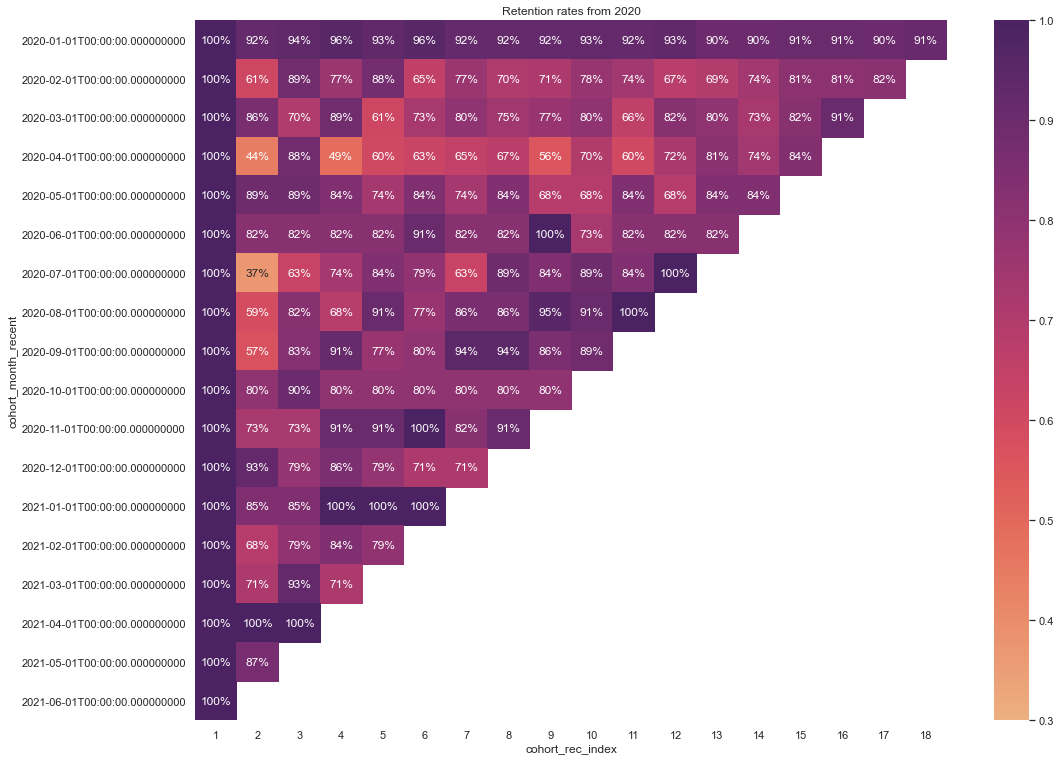

In [26]:
plt.figure(figsize = (15,12))
plt.title('Retention rates from 2020')
sns.heatmap(data = retention_since2020,
           annot = True,
           fmt = '.0%',
           vmin = 0.3,
           vmax = 1,
           cmap = 'flare')


We can see that, unlike the retail industry where the retantion rates are substantially lower, in this particular case the stores that are buying from the state department are more prone to order again every month.

We can see that for the months of July and August 2020, all the stores that made their first purchase in these 2 month ended up ordering again in June of 2021. 

## RFM Segmentation 

**This is a behavioral customer segmentation based on three metrics:**
* Recency(R)
* Frequency(F)
* Monetary Value(M)

The RFM values can be grouped in multiple ways:
- Percentiles(for e.g. quantiles)
- Pareto 80/20 cut
- Custom - based on business knowledge

We are going to use percentile based grouping.


The process of percentile grouping involves:
- Sorting the customers based on each of the 3 metrics
- Breaking customers into a pre-defined number of groups of equal size
- Assign a label to each group



### Building Recency, Frequency and MonetaryValue features

Recency is the a metric that calculates the time passed since the last order.

In [27]:
df

,Date,Store Name,Sale (Dollars),inv_month,cohort_month,cohort_index
0,2016-03-24,Hillstreet News and Tobacco,243.00,2016-03-01,2012-01-01,51
1,2016-03-24,Hillstreet News and Tobacco,156.12,2016-03-01,2012-01-01,51
2,2016-03-24,Hillstreet News and Tobacco,477.60,2016-03-01,2012-01-01,51
3,2016-03-17,Hillstreet News and Tobacco,450.00,2016-03-01,2012-01-01,51
4,2016-03-24,Hillstreet News and Tobacco,79.56,2016-03-01,2012-01-01,51
...,...,...,...,...,...,...
21641140,2017-11-17,"Cats Eye Distillery, LLC",346.56,2017-11-01,2017-11-01,1
21641141,2018-05-23,"Green Frog Distillery, LLC",157.50,2018-05-01,2018-05-01,1
21641142,2018-07-26,Templeton Distilling LLC,246.72,2018-07-01,2018-07-01,1
21641143,2020-10-15,Rock River Distillation Company,1620.00,2020-10-01,2020-10-01,1


In [28]:
df = df.drop(['inv_month', 'cohort_month', 'cohort_index'], axis = 1)

Before moving the grouping we have to keep in mind that each line does not represent a distinct invoice, but rather a distinct product from each invoice. So we will group by **Date** and **Store** to solve this small issue.

In [29]:
df = df.groupby(['Date', 'Store Name']).sum()

In [30]:
df = df.reset_index()
df

,Date,Store Name,Sale (Dollars)
0,2012-01-03,AJ'S LIQUOR II,2466.64
1,2012-01-03,Adventureland Inn,188.12
2,2012-01-03,After 5 Somewhere,2445.92
3,2012-01-03,Ameristar Casino / Council Bluffs,12291.89
4,2012-01-03,Anamosa Family Foods,8110.91
...,...,...,...
512328,2021-06-30,Wines and Spirits,10535.02
512329,2021-06-30,Yesway Store # 10034/ Belmond,1439.34
512330,2021-06-30,Yesway Store # 1029/ Clarion,1840.62
512331,2021-06-30,Yesway Store # 1036/ Kanawha,1066.74


Now let's use groupby to obtain some of the desired columns

In [31]:
rfm_prelim = df.groupby('Store Name').agg({'Date': ['max','count'], 'Sale (Dollars)':'sum'})
rfm_prelim

Date       Sale (Dollars)
                                         max count            sum
Store Name                                                       
'Da Booze Barn / West Bend        2021-06-30    82      204930.02
10th Hole Inn & Suite / Gift Shop 2021-06-28    13       16221.98
16th Ave BP / Cedar Rapids        2021-05-24    11       26917.82
1st Ave BP / Cedar Rapids         2021-05-10    12       20904.70
1st Stop Beverage Shop            2021-06-25   235     1851350.37
...                                      ...   ...            ...
Z's Quickbreak                    2016-08-15   177      251324.69
Zapf's Pronto Market              2020-03-20   207      316601.53
goPuff / Ames                     2021-06-24    79      148069.68
goPuff / Iowa City                2021-06-29    47      185477.64
k food mart / Monticello          2019-11-16     1        3758.37

[2506 rows x 3 columns]

In [32]:
rfm_prelim.columns = ['Recent_date', 'Frequency', 'MonetaryValue']
rfm_prelim

,Recent_date,Frequency,MonetaryValue
Store Name,,,
'Da Booze Barn / West Bend,2021-06-30,82,204930.02
10th Hole Inn & Suite / Gift Shop,2021-06-28,13,16221.98
16th Ave BP / Cedar Rapids,2021-05-24,11,26917.82
1st Ave BP / Cedar Rapids,2021-05-10,12,20904.70
1st Stop Beverage Shop,2021-06-25,235,1851350.37
...,...,...,...
Z's Quickbreak,2016-08-15,177,251324.69
Zapf's Pronto Market,2020-03-20,207,316601.53
goPuff / Ames,2021-06-24,79,148069.68


Let's see what is the max date of any purchase as a reference for our recency calculation

In [33]:
rfm_prelim.Recent_date.max()

Timestamp('2021-06-30 00:00:00')

In [34]:
max_date = rfm_prelim.Recent_date.max()

In [35]:
rfm_prelim['Recency'] = max_date - rfm_prelim['Recent_date']

rfm_prelim

,Recent_date,Frequency,MonetaryValue,Recency
Store Name,,,,
'Da Booze Barn / West Bend,2021-06-30,82,204930.02,0 days
10th Hole Inn & Suite / Gift Shop,2021-06-28,13,16221.98,2 days
16th Ave BP / Cedar Rapids,2021-05-24,11,26917.82,37 days
1st Ave BP / Cedar Rapids,2021-05-10,12,20904.70,51 days
1st Stop Beverage Shop,2021-06-25,235,1851350.37,5 days
...,...,...,...,...
Z's Quickbreak,2016-08-15,177,251324.69,1780 days
Zapf's Pronto Market,2020-03-20,207,316601.53,467 days
goPuff / Ames,2021-06-24,79,148069.68,6 days


In [36]:
rfm = rfm_prelim.drop('Recent_date', axis= 1)
rfm['Recency'] = rfm['Recency'].dt.days
rfm

,Frequency,MonetaryValue,Recency
Store Name,,,
'Da Booze Barn / West Bend,82,204930.02,0
10th Hole Inn & Suite / Gift Shop,13,16221.98,2
16th Ave BP / Cedar Rapids,11,26917.82,37
1st Ave BP / Cedar Rapids,12,20904.70,51
1st Stop Beverage Shop,235,1851350.37,5
...,...,...,...
Z's Quickbreak,177,251324.69,1780
Zapf's Pronto Market,207,316601.53,467
goPuff / Ames,79,148069.68,6


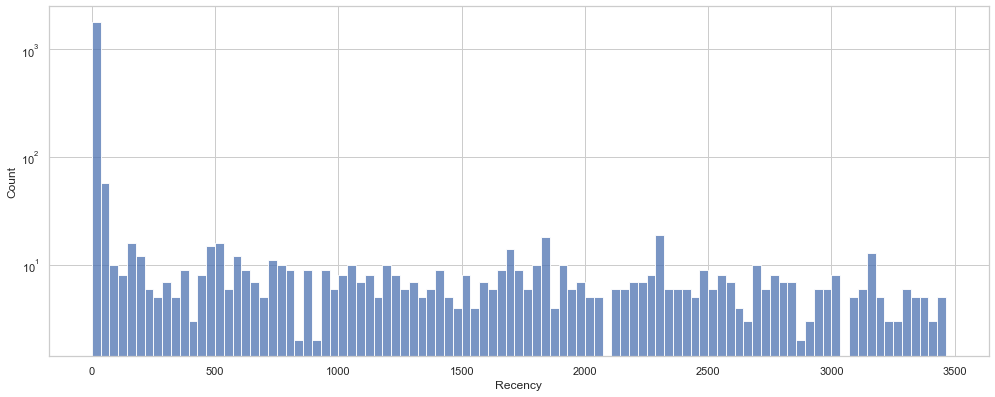

In [81]:
sns.histplot(rfm.Recency)
plt.yscale('log')

<AxesSubplot:xlabel='Frequency', ylabel='Count'>

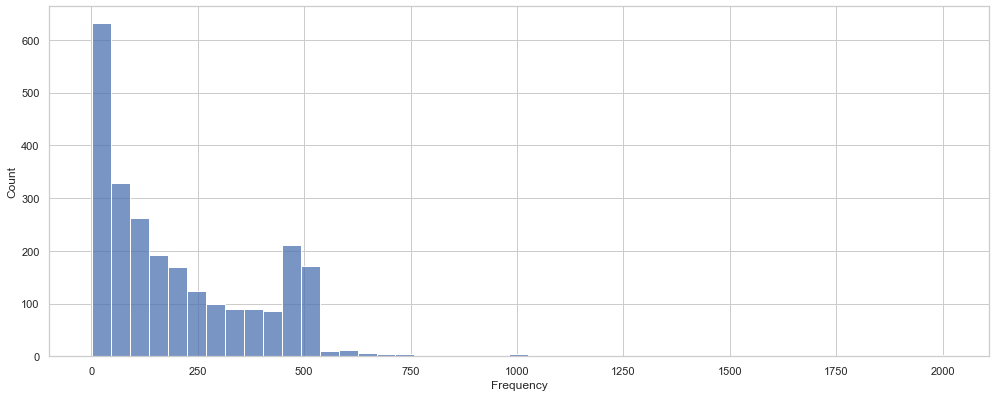

In [79]:
sns.histplot(rfm.Frequency)

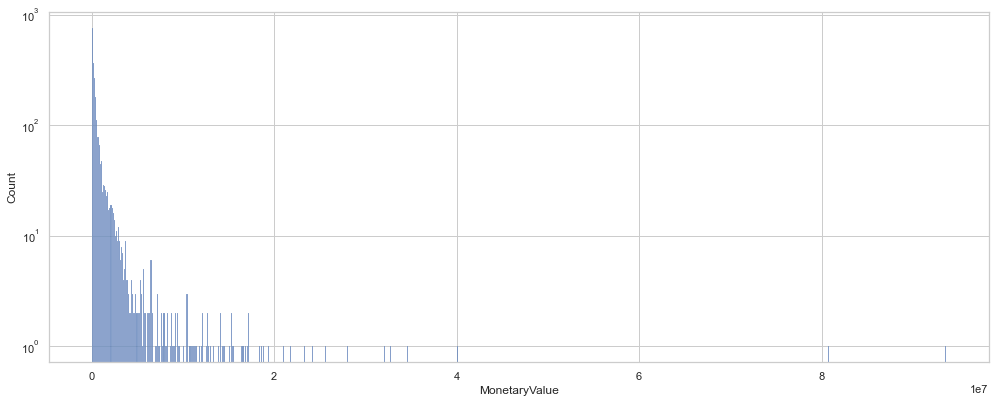

In [78]:
sns.histplot(rfm.MonetaryValue)
plt.yscale('log')

### Building RFM segments

Using the data created, we will calculate quartile value for each column and name them **R, F and M**

For recency, the smaller the value, the higher the score. For the other two metrics, the higher the value, the higher the score.

In [40]:
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(rfm['Recency'], 4, labels = r_labels)
rfm = rfm.assign(R = r_quartiles.values)
rfm

,Frequency,MonetaryValue,Recency,R
Store Name,,,,
'Da Booze Barn / West Bend,82,204930.02,0,4
10th Hole Inn & Suite / Gift Shop,13,16221.98,2,4
16th Ave BP / Cedar Rapids,11,26917.82,37,2
1st Ave BP / Cedar Rapids,12,20904.70,51,2
1st Stop Beverage Shop,235,1851350.37,5,3
...,...,...,...,...
Z's Quickbreak,177,251324.69,1780,1
Zapf's Pronto Market,207,316601.53,467,1
goPuff / Ames,79,148069.68,6,3


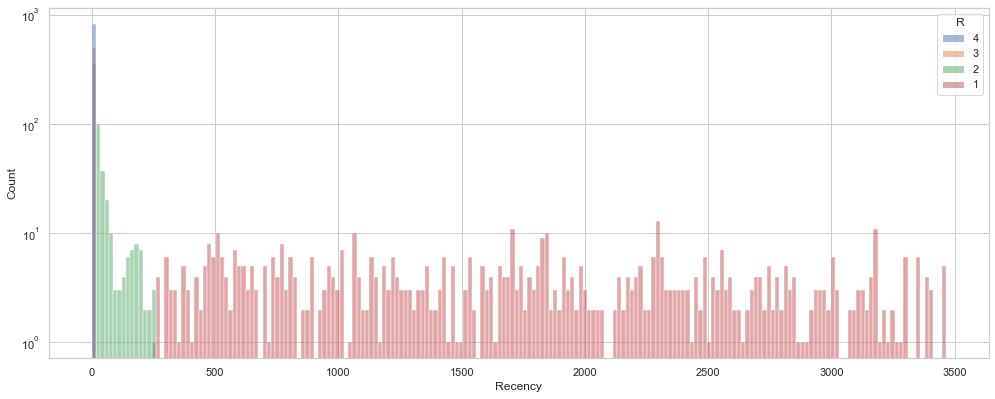

In [41]:
sns.histplot(data = rfm, x='Recency', hue = 'R', bins = 200)
plt.yscale('log')

In [42]:
f_labels = range(1,5)
f_quartiles = pd.qcut(rfm['Frequency'], 4, labels = f_labels)
rfm = rfm.assign(F = f_quartiles.values)
rfm

,Frequency,MonetaryValue,Recency,R,F
Store Name,,,,,
'Da Booze Barn / West Bend,82,204930.02,0,4,2
10th Hole Inn & Suite / Gift Shop,13,16221.98,2,4,1
16th Ave BP / Cedar Rapids,11,26917.82,37,2,1
1st Ave BP / Cedar Rapids,12,20904.70,51,2,1
1st Stop Beverage Shop,235,1851350.37,5,3,3
...,...,...,...,...,...
Z's Quickbreak,177,251324.69,1780,1,3
Zapf's Pronto Market,207,316601.53,467,1,3
goPuff / Ames,79,148069.68,6,3,2


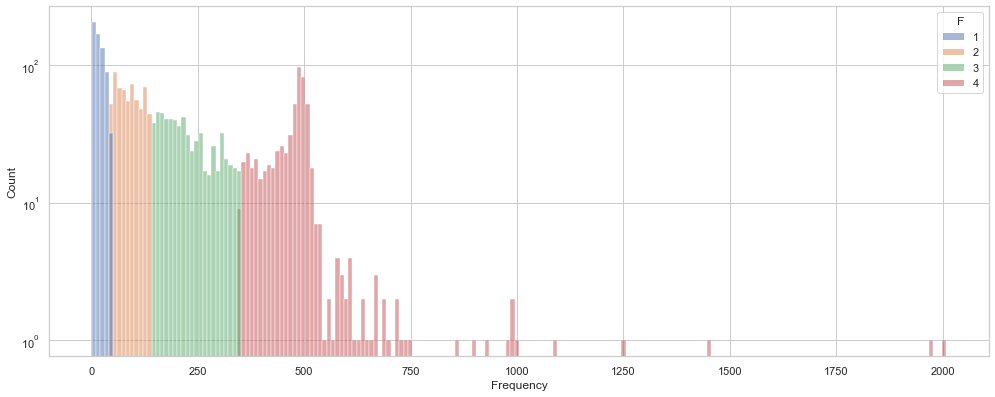

In [43]:
sns.histplot(data = rfm, x='Frequency', hue = 'F', bins = 200)
plt.yscale('log')

In [44]:
m_labels = range(1,5)
m_quartiles = pd.qcut(rfm['MonetaryValue'], 4, labels = m_labels)
rfm = rfm.assign(M = m_quartiles.values)
rfm

,Frequency,MonetaryValue,Recency,R,F,M
Store Name,,,,,,
'Da Booze Barn / West Bend,82,204930.02,0,4,2,2
10th Hole Inn & Suite / Gift Shop,13,16221.98,2,4,1,1
16th Ave BP / Cedar Rapids,11,26917.82,37,2,1,1
1st Ave BP / Cedar Rapids,12,20904.70,51,2,1,1
1st Stop Beverage Shop,235,1851350.37,5,3,3,4
...,...,...,...,...,...,...
Z's Quickbreak,177,251324.69,1780,1,3,2
Zapf's Pronto Market,207,316601.53,467,1,3,3
goPuff / Ames,79,148069.68,6,3,2,2


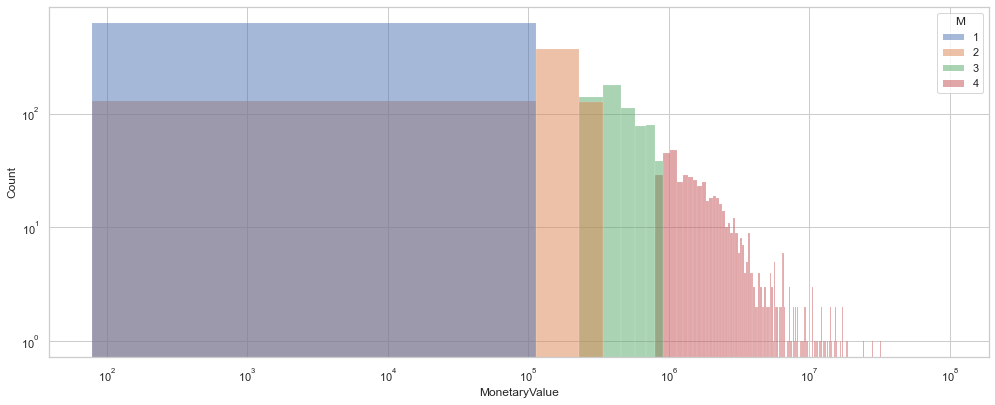

In [45]:
sns.histplot(data = rfm, x='MonetaryValue', hue = 'M')
plt.yscale('log')
plt.xscale('log')

### Building RFM Segment and RFM Score

For the RFM segment we will just concatenate the 3 metrics.

For the RFM score we will add the 3 metrics.

In [52]:
rfm['R'] = rfm['R'].astype(int)

In [53]:
rfm['F'] = rfm['F'].astype(int)
rfm['M'] = rfm['M'].astype(int)

In [54]:
def join_rfm(x):
    return str(x['R']) + str(x['F']) + str(x['M'])

rfm['RFM_Segment'] = rfm.apply(join_rfm, axis = 1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)

rfm

,Frequency,MonetaryValue,Recency,R,F,M,RFM_Segment,RFM_Score
Store Name,,,,,,,,
'Da Booze Barn / West Bend,82,204930.02,0,4,2,2,422,8
10th Hole Inn & Suite / Gift Shop,13,16221.98,2,4,1,1,411,6
16th Ave BP / Cedar Rapids,11,26917.82,37,2,1,1,211,4
1st Ave BP / Cedar Rapids,12,20904.70,51,2,1,1,211,4
1st Stop Beverage Shop,235,1851350.37,5,3,3,4,334,10
...,...,...,...,...,...,...,...,...
Z's Quickbreak,177,251324.69,1780,1,3,2,132,6
Zapf's Pronto Market,207,316601.53,467,1,3,3,133,7
goPuff / Ames,79,148069.68,6,3,2,2,322,7


Let's see how many Stores are in each of our segments

In [55]:
rfm.groupby('RFM_Segment').size().sort_values(ascending = False)

RFM_Segment
444    289
211    220
111    182
344    160
122    141
222    125
433    118
422    116
133     99
411     96
233     91
333     81
322     67
311     59
443     53
134     52
343     47
434     43
132     39
423     36
123     32
432     27
334     25
232     24
121     24
243     24
221     23
144     22
212     19
412     18
112     17
421     17
312     17
244     16
332     16
223     14
143     14
323     13
234     12
321      6
424      5
124      3
413      1
213      1
113      1
313      1
dtype: int64

And by score

In [56]:
rfm.groupby('RFM_Score').size().sort_values(ascending = False)

RFM_Score
6     316
8     303
12    289
4     261
11    256
7     243
5     243
10    211
9     202
3     182
dtype: int64

### Metrics summary per RFM scores

Finally, let's view our Summary metrics per RFM score.

In [57]:
sum_metrics = rfm.groupby('RFM_Score').agg({'Recency':'mean', 'Frequency':'mean', 'MonetaryValue': ['mean','count']}).round(1)
sum_metrics

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3          2080.0      16.2       24726.9   182
4           366.6      21.3       44589.0   261
5          1062.9      68.7      120773.1   243
6           390.2      78.4      156734.3   316
7           578.7     145.3      316769.9   243
8           308.7     170.9      500678.2   303
9            86.3     253.5      720828.4   202
10            7.9     293.5      762875.3   211
11            3.7     435.1     3012210.0   256
12            0.9     521.6     5408756.7   289

In [58]:
sum_metrics.columns = ['mean_r', 'mean_f', 'mean_m', 'count']

Both RFM_Segment and RFM_Score can be used to better understand the customers and to develop personalized Marketing Campaigns fro different types of customers.

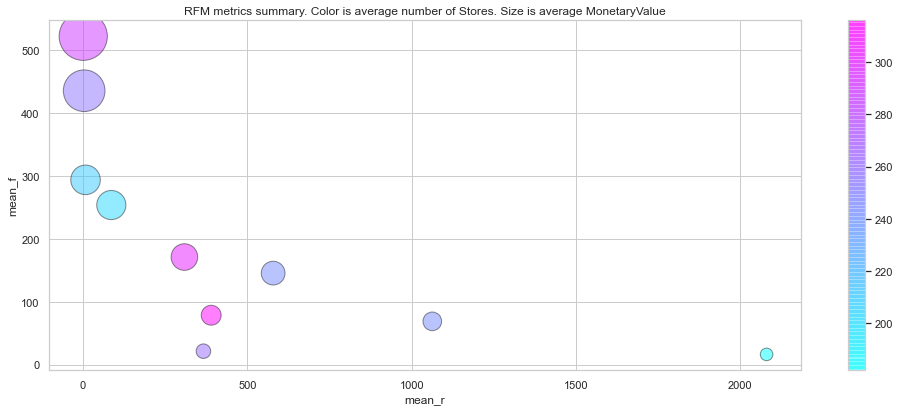

In [66]:
color = sum_metrics['count']
area = sum_metrics.mean_m**(1/2)

sum_metrics.plot.scatter(x ='mean_r', y ='mean_f' ,
                     c = color, colormap=matplotlib.cm.get_cmap('cool'),
                     s = area, edgecolors = 'k',
                     sharex=False, figsize = (15,6), alpha = 0.5)
plt.title('RFM metrics summary. Color is average number of Stores. Size is average MonetaryValue')

plt.show()

Another way to classify Customers based on RFM besides RFM segment or score is to used Unsupervised clustering.

We will explore this in the remainder of this Notebook.

### Preprocessing data before K-Means Unsupervised Clustering

The prerequisites for K-Means are the following:
1. Symetric distribution of variables(not skewed)
2. Variable with same mean
3. Varaible with same variance

#### Applying logarithmic transform

In [85]:
rfm_clustering = rfm[['Recency','Frequency','MonetaryValue']]
rfm_clustering.describe()

,Recency,Frequency,MonetaryValue
count,2506.000000,2506.000000,2.506000e+03
mean,443.059856,204.442538,1.182971e+06
std,873.538370,191.504640,3.728119e+06
min,0.000000,1.000000,7.800000e+01
25%,2.000000,45.000000,8.568430e+04
50%,6.000000,141.000000,2.737289e+05
75%,246.000000,349.000000,8.600355e+05
max,3465.000000,2008.000000,9.362904e+07


In [89]:
rfm_clustering['log_r'] = np.log(rfm_clustering.Recency+1) # adding 1 because min value = 0, which is -inf when applying log trasform
rfm_clustering['log_f'] = np.log(rfm_clustering.Frequency)
rfm_clustering['log_m'] = np.log(rfm_clustering.MonetaryValue)
rfm_clustering.describe()

,Recency,Frequency,MonetaryValue,log_r,log_f,log_m
count,2506.000000,2506.000000,2.506000e+03,2506.000000,2506.000000,2506.000000
mean,443.059856,204.442538,1.182971e+06,3.059118,4.654245,12.492595
std,873.538370,191.504640,3.728119e+06,2.648233,1.418901,1.790032
min,0.000000,1.000000,7.800000e+01,0.000000,0.000000,4.356709
25%,2.000000,45.000000,8.568430e+04,1.098612,3.806662,11.358425
50%,6.000000,141.000000,2.737289e+05,1.945910,4.948760,12.519892
75%,246.000000,349.000000,8.600355e+05,5.509388,5.855072,13.664729
max,3465.000000,2008.000000,9.362904e+07,8.150756,7.604894,18.354851


#### Modifying our features to have the same mean

In [90]:
rfm_clustering = rfm_clustering[['log_r', 'log_f', 'log_m']]

In [91]:
rfm_clustering = rfm_clustering - rfm_clustering.mean()


In [92]:
rfm_clustering.describe().round(2)

,log_r,log_f,log_m
count,2506.00,2506.00,2506.00
mean,-0.00,-0.00,0.00
std,2.65,1.42,1.79
min,-3.06,-4.65,-8.14
25%,-1.96,-0.85,-1.13
50%,-1.11,0.29,0.03
75%,2.45,1.20,1.17
max,5.09,2.95,5.86


#### And to have the same std

In [93]:
rfm_clustering = rfm_clustering / rfm_clustering.std()

In [94]:
rfm_clustering.describe().round(2)

,log_r,log_f,log_m
count,2506.00,2506.00,2506.00
mean,-0.00,-0.00,0.00
std,1.00,1.00,1.00
min,-1.16,-3.28,-4.55
25%,-0.74,-0.60,-0.63
50%,-0.42,0.21,0.02
75%,0.93,0.85,0.65
max,1.92,2.08,3.27


We can also use StandardScaler for the same result.

#### Using StandardScaler

In [97]:
rfm_clustering_ss = rfm[['Recency','Frequency','MonetaryValue']]

In [100]:
scaler = StandardScaler()
scaler.fit(rfm_clustering_ss)
rfm_clustering_ss = scaler.transform(rfm_clustering_ss)
rfm_clustering_ss

array([[-0.5073026 , -0.63949873, -0.26239399],
       [-0.5050126 , -0.99987523, -0.31302159],
       [-0.46493767, -1.01032093, -0.31015205],
       ...,
       [-0.50043261, -0.65516728, -0.27764879],
       [-0.5061576 , -0.82229841, -0.26761278],
       [ 0.17053615, -1.0625494 , -0.31636539]])

### KMeans Clustering

As methods of choosing the optimal K clusters we will use:
   1. Elbow method
   2. Silhouette scores and plots

In [105]:
def clustering_plotting_elbow(df, n = 10):
    ks = range(1,n+1)
    inertias = []
    for k in ks:
        model = KMeans(n_clusters = k, random_state = 123)
        model.fit(df)
        inertias.append(model.inertia_)

    plt.plot(ks, inertias, '-o')
    plt.xlabel('Number of Clusters, k')
    plt.ylabel('Inertia')
    plt.xticks(ks)
    plt.show()

In [106]:
def plotting_silhouette(df, n = 10):
    range_n_clusters = list(range(2,n+1))

    for n_clusters in range_n_clusters:
        fig, ax1 = plt.subplots(1,1)
        fig.set_size_inches(18, 7)
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate 
# them clearly.
        ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator seed of 123 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=123)
        cluster_labels = clusterer.fit_predict(df)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(df, cluster_labels)
        print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
# Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values =  sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, 
                              edgecolor=color, alpha=0.7)

# Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

# Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

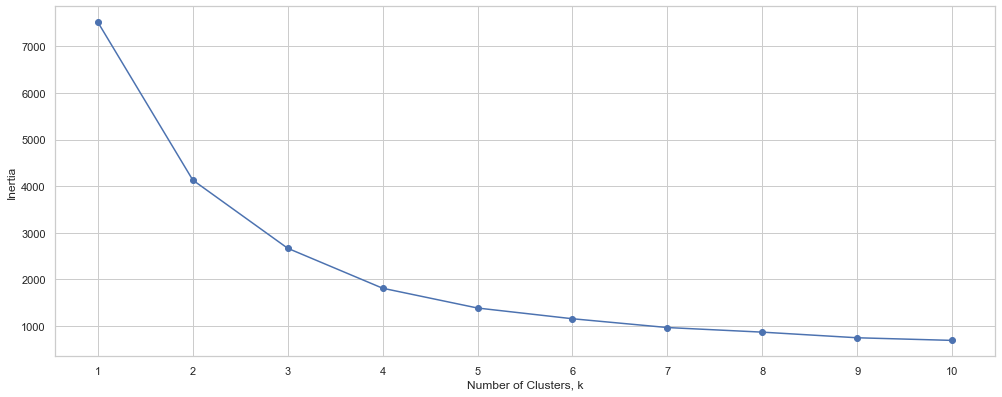

In [107]:
clustering_plotting_elbow(rfm_clustering)

For n_clusters = 2 The average silhouette_score is : 0.4015280027018095
For n_clusters = 3 The average silhouette_score is : 0.46808655675014255
For n_clusters = 4 The average silhouette_score is : 0.4609456203154566
For n_clusters = 5 The average silhouette_score is : 0.4258804378866342
For n_clusters = 6 The average silhouette_score is : 0.420652271755613
For n_clusters = 7 The average silhouette_score is : 0.3921723440779897
For n_clusters = 8 The average silhouette_score is : 0.36760710172203803
For n_clusters = 9 The average silhouette_score is : 0.3568040922861687
For n_clusters = 10 The average silhouette_score is : 0.3525598619569875


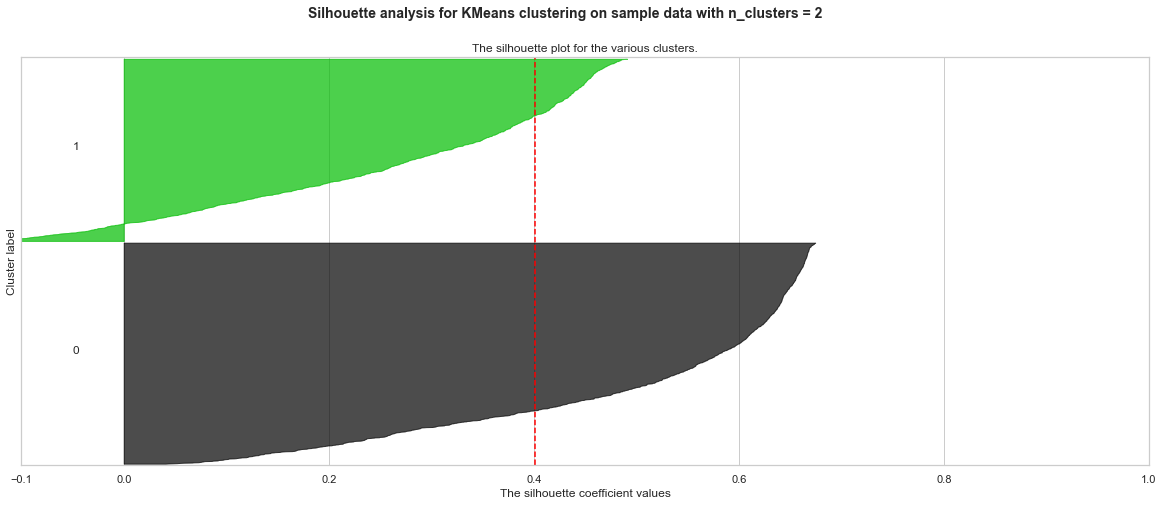

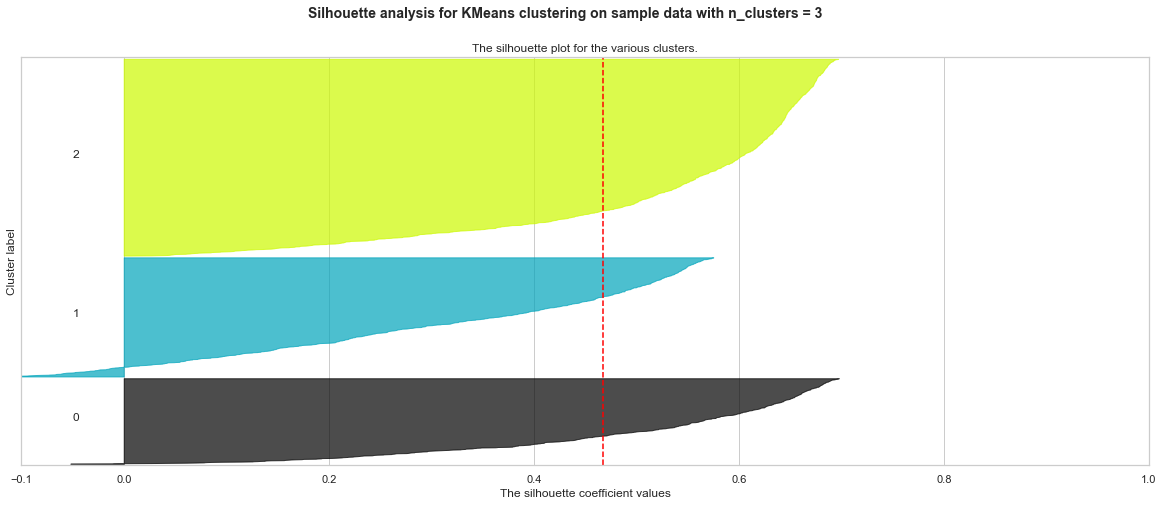

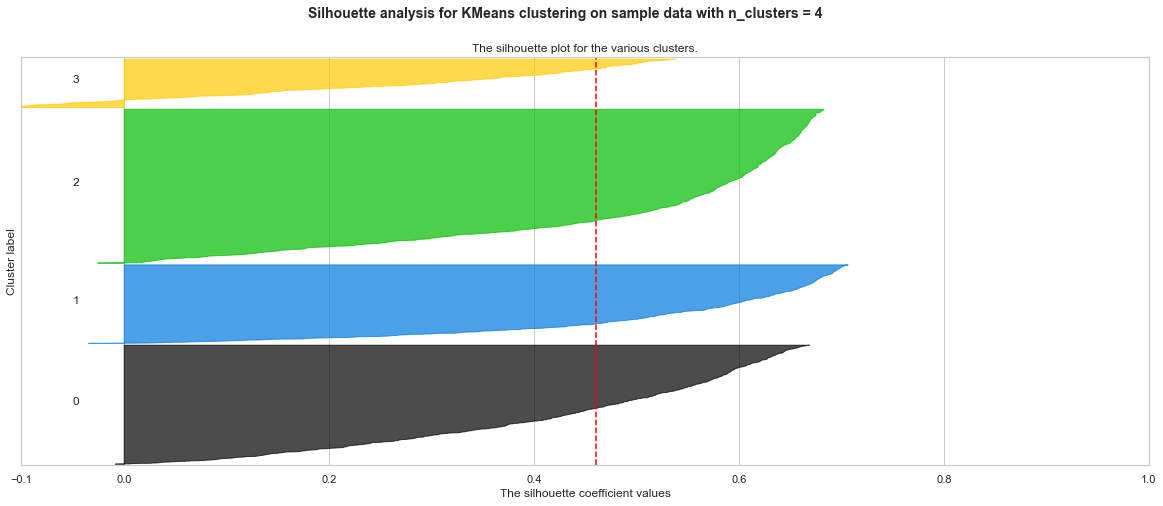

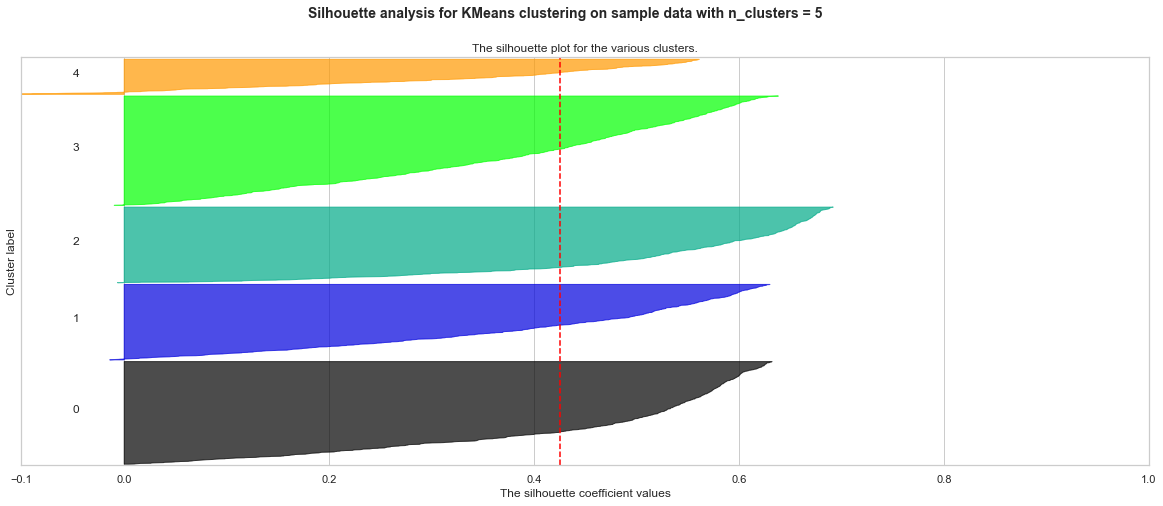

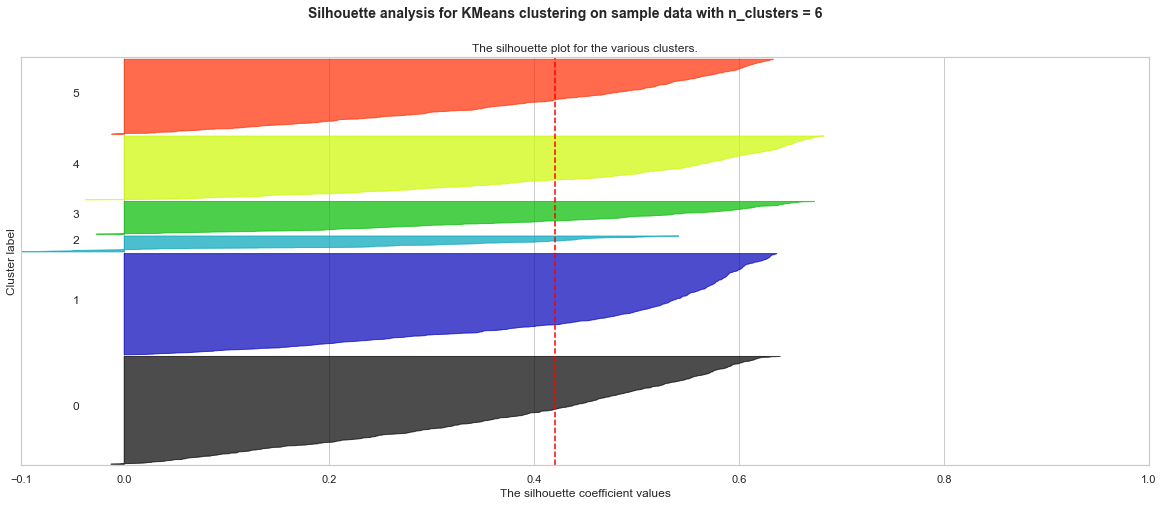

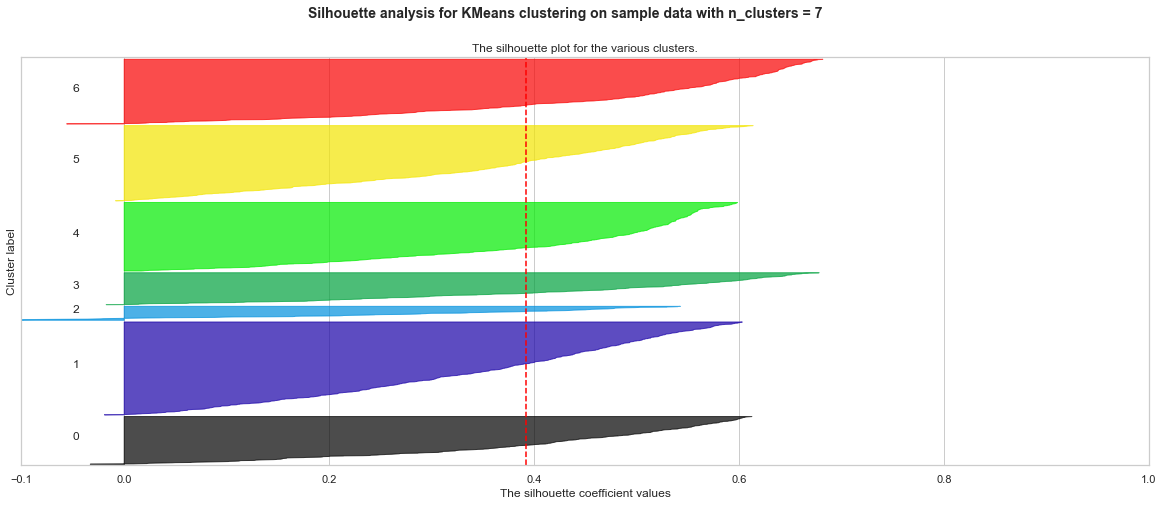

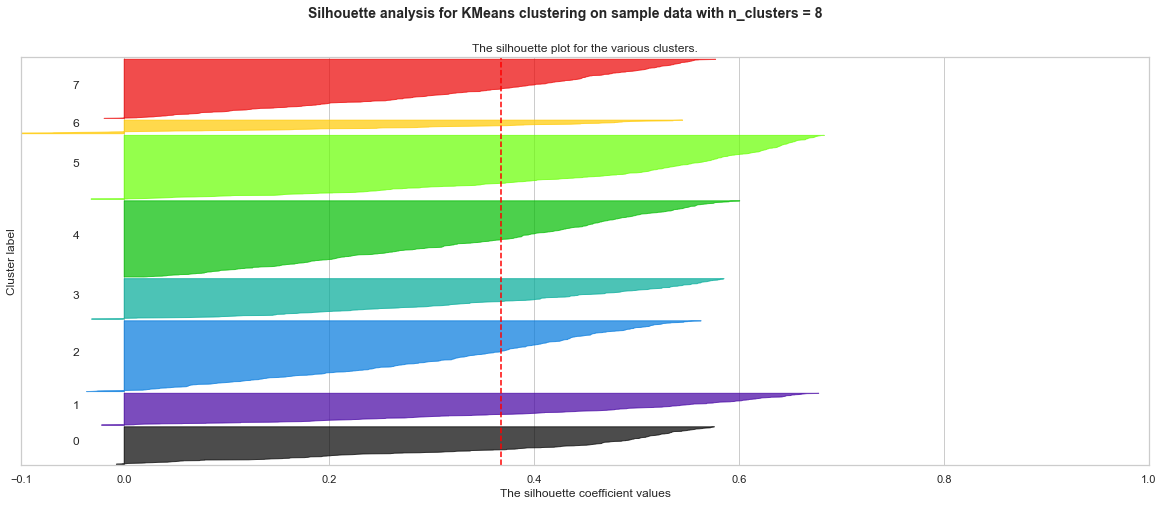

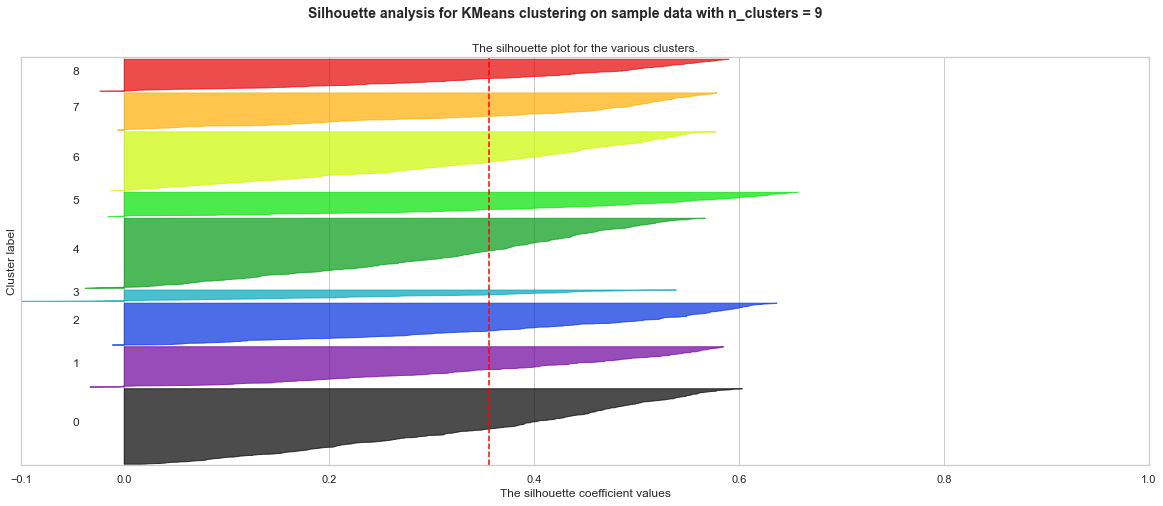

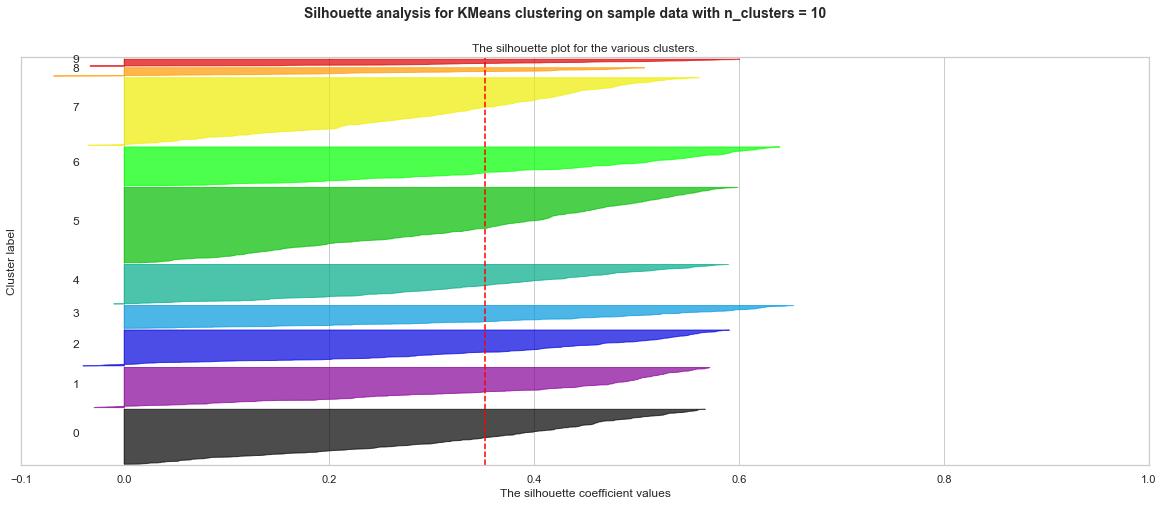

In [108]:
plotting_silhouette(rfm_clustering)

I would say that the optimal number of clusters based on both Silhouette scores and elbow is 4. We can observe a slight elbow at 4 clusters, and the silhouette score for 4 clusters is one of the highest, with 0.46.

In [110]:
rfm

,Frequency,MonetaryValue,Recency,R,F,M,RFM_Segment,RFM_Score
Store Name,,,,,,,,
'Da Booze Barn / West Bend,82,204930.02,0,4,2,2,422,8
10th Hole Inn & Suite / Gift Shop,13,16221.98,2,4,1,1,411,6
16th Ave BP / Cedar Rapids,11,26917.82,37,2,1,1,211,4
1st Ave BP / Cedar Rapids,12,20904.70,51,2,1,1,211,4
1st Stop Beverage Shop,235,1851350.37,5,3,3,4,334,10
...,...,...,...,...,...,...,...,...
Z's Quickbreak,177,251324.69,1780,1,3,2,132,6
Zapf's Pronto Market,207,316601.53,467,1,3,3,133,7
goPuff / Ames,79,148069.68,6,3,2,2,322,7


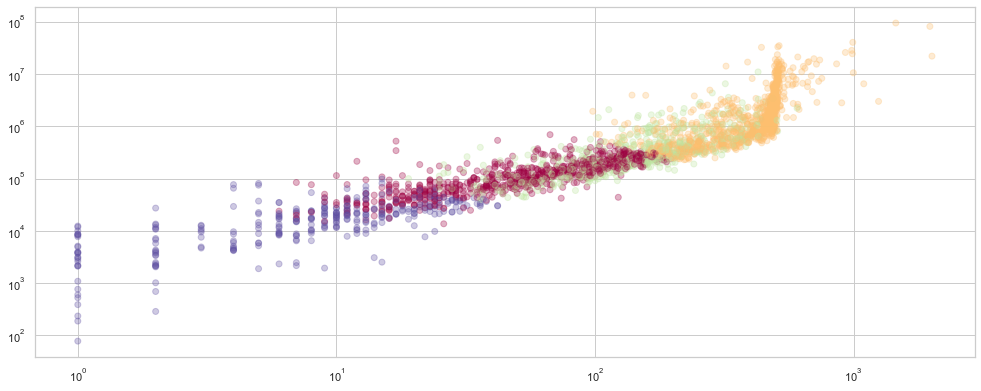

In [114]:
KMeans_model = KMeans(n_clusters = 4)
KMeans_model.fit(rfm_clustering)
labels = KMeans_model.predict(rfm_clustering)

plt.scatter(rfm.Frequency,rfm.MonetaryValue, alpha = 0.3, c = labels, cmap = 'Spectral')
plt.xscale('log')
plt.yscale('log')

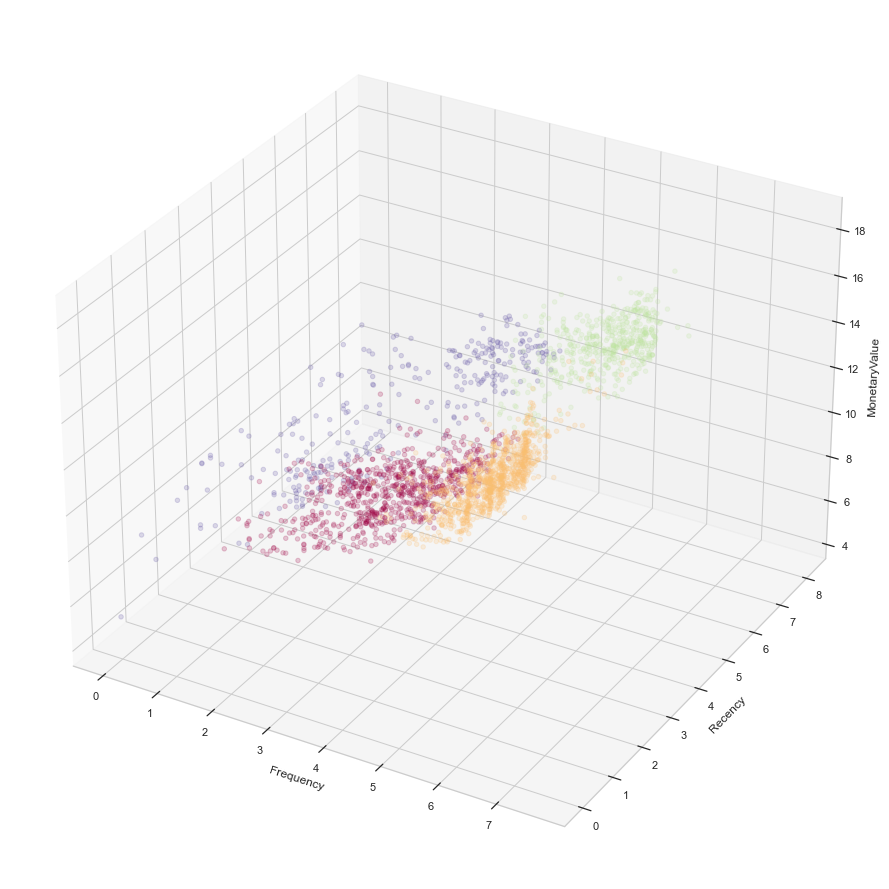

In [116]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection = '3d')


ax.set_xlabel("Frequency")
ax.set_ylabel("Recency")
ax.set_zlabel("MonetaryValue")

ax.scatter(np.log(rfm.Frequency), np.log(rfm.Recency+1), np.log(rfm.MonetaryValue), c = labels, alpha = 0.2, cmap = 'Spectral')

plt.show()

In [117]:
rfm['cust_segmentation'] = labels.astype('int')
rfm

,Frequency,MonetaryValue,Recency,R,F,M,RFM_Segment,RFM_Score,cust_segmentation
Store Name,,,,,,,,,
'Da Booze Barn / West Bend,82,204930.02,0,4,2,2,422,8,0
10th Hole Inn & Suite / Gift Shop,13,16221.98,2,4,1,1,411,6,0
16th Ave BP / Cedar Rapids,11,26917.82,37,2,1,1,211,4,3
1st Ave BP / Cedar Rapids,12,20904.70,51,2,1,1,211,4,3
1st Stop Beverage Shop,235,1851350.37,5,3,3,4,334,10,1
...,...,...,...,...,...,...,...,...,...
Z's Quickbreak,177,251324.69,1780,1,3,2,132,6,2
Zapf's Pronto Market,207,316601.53,467,1,3,3,133,7,2
goPuff / Ames,79,148069.68,6,3,2,2,322,7,0


### Finally, let's see how the 3 metrics involved are aggregated per cluster

In [118]:
clust_metrics = rfm.groupby('cust_segmentation').agg({'Recency':'mean', 'Frequency':'mean', 'MonetaryValue': ['mean','count']}).round(1)
clust_metrics

Recency Frequency MonetaryValue      
                     mean      mean          mean count
cust_segmentation                                      
0                     7.7      67.1      137658.4   745
1                     5.3     390.9     2705848.9   963
2                  1507.5     166.5      504989.9   495
3                  1166.0      11.5       20683.2   303

It seems that **Cluster 0** has the folowing characteristics:
   * low recency
   * medium - low frequency
   * medium - low monetaryValue
These stores have bought recently, but only bought 67 times in the past 8 years, with an average of 137000 USD. 
These might be the smaller liquor stores that are buying consistent just every other month because it takes a lot to sell their products.
    
**Cluster 1** has the folowing characteristics:
   * low recency
   * very high frequency
   * very high monetaryValue 
These stores have bough recently, with a high frequency of 390 times in the past 8 years( an average of once per week) and a MonetaryValue of 2,700,000.
This is also the biggest group, with 963 stores.
This are the big Liquor stores, with a lot of traffic and that are looking for constant resupply.
    
**Cluster 2** has the folowing characteristics:
   * high recency
   * very high frequency
   * very high monetaryValue 
O average these stores have not bough from the State for 1500 days. That is almost 5 year.
So even their frequency is not very low and the Monetary Value ios quite high, these are the Stores who stopped buying from the State for different reasons.
These is one of the main group to be targeted with Marketing Campaigns.

**Cluster 3** has the folowing characteristics:
   * high recency
   * very low frequency
   * very low monetaryValue 
These are the small stores that stopped buying from the state more than 3 years ago. Their average Monetary Value is only 20000USD and they only bought 11 in the last 8 years on average.
this is a group that doesn't present any interest.